## Calculate skill of S2S model ECMWF for daily global reforecasts

In [1]:
import climpred
import xarray as xr
import cartopy.crs as ccrs
from xclim.core import units
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cfeature
import pandas as pd

/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
s2s_ensemble_path = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/s2s_tp_input.nc"
era_file_winter = "/home/egauillard/data/tp_1940_2023_1deg_7res_winter.nc"
vae_ensemble_path =
earthformer_ensemble_path = 
clim_std_path= 



### Get the quantiles of the observations

In [ ]:
weekly_obs = xr.open_dataset(era_file_winter)
# transform mean of tp in sum
weekly_obs["tp"] = weekly_obs["tp"] * 7

# compute the quantile
obs_edges = (
    weekly_obs["tp"]
    .quantile(q=[1 / 3, 2 / 3], dim="time", skipna=False)
    .rename({"quantile": "category_edge"})
)

### Open S2S forecast data and adapt it to our forecast lead time

In [3]:
# Charger et traiter les données
s2s = xr.open_dataset(s2s_ensemble_path)
s2s = s2s["tp"]
units.convert_units_to(s2s, 'mm', "hydro")
s2s.attrs["units"] = "mm"

In [ ]:
# garder seuelment les lead_time [7, 14, 21, 28]
# et dcp changer les values de tp en faisant lead_time = 14 - lead_time=7 etc car les valeurs sont accumulées
# avec les lead time 
lead_times = [7, 14, 21, 28]

s2s = s2s.sel(lead_time= lead_times)
for i in range(1, len(lead_times)):
    s2s.sel(lead_time=lead_times[i]).values = s2s.sel(lead_time=lead_times[i]).values - s2s.sel(lead_time=lead_times[i-1]).values

### Open models VAE and Earthformer predictions

In [ ]:
vae_model =
earthformer_model =

In [ ]:
# put every prediction dataset only keep the forecast_time in common


### Compare the performance of all models respective to the climatology

In [ ]:

s2s_med = s2s.sel(latitude=slice(med_lats[0], med_lats[1]), longitude=slice(med_lons[0], med_lons[1]))
sample = s2s_med.isel(forecast_time=1).isel(realization=7)
sample = sample.isel(lead_time=30)
 

# Créer le plot
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

# Tracer les données
im = ax.pcolormesh(sample.longitude, sample.latitude, sample.values,
                   transform=ccrs.PlateCarree(), cmap='Blues')

# Ajouter les côtes et les frontières
ax.coastlines(resolution='50m', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# Ajouter les lignes de grille principales
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Obtenir la résolution des données
lat_res = np.abs(sample.latitude[1] - sample.latitude[0])
lon_res = np.abs(sample.longitude[1] - sample.longitude[0])

# Ajouter des lignes de grille mineures pour montrer les cellules individuelles
ax.gridlines(crs=ccrs.PlateCarree(), draw_la bels=False,
             linewidth=0.2, color='gray', alpha=0.2, linestyle=':',
             xlocs=np.arange(sample.longitude.min(), sample.longitude.max() + lon_res, lon_res),
             ylocs=np.arange(sample.latitude.min(), sample.latitude.max() + lat_res, lat_res))

# Définir les limites de la carte pour montrer seulement la zone de sample
ax.set_extent([sample.longitude.min(), sample.longitude.max(), 
               sample.latitude.min(), sample.latitude.max()], 
              crs=ccrs.PlateCarree())

# Ajouter une barre de couleur
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.08, aspect=30)
cbar.set_label('Précipitations (mm/jour)', fontsize=12)

plt.title('Prévision des précipitations avec cellules de grille', fontsize=16)
plt.tight_layout()
plt.show()

In [2]:
def transform_data(da):
    # Créer un masque pour les valeurs non-NaN
    mask = ~np.isnan(da).any(dim=['latitude', 'longitude'])
    
    # Initialiser une liste pour stocker les valid_times de chaque échantillon
    all_valid_times = []
    
    # Pour chaque échantillon, trouver les valid_times correspondant aux données non-NaN
    for sample in da.sample:
        sample_mask = mask.sel(sample=sample)
        valid_times = da.time.where(sample_mask, drop=True)
        all_valid_times.append(valid_times)
    
    # Créer un nouveau DataArray avec les dimensions (sample, valid_time)
    new_da = xr.DataArray(
        np.array([da.sel(sample=s, time=vt).values for s, vt in zip(da.sample, all_valid_times)]),
        coords={
            'sample': da.sample,
            'valid_time': xr.DataArray(all_valid_times, dims=('sample', 'valid_time')),
            'latitude': da.latitude,
            'longitude': da.longitude
        },
        dims=['sample', 'valid_time', 'latitude', 'longitude']
    )
    
    return new_da

preds = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20241008_155846/inference_plots/model-skill-epoch=004-valid_skill_score=0.00.ckpt/all_predictions.nc"

pred_data = xr.open_dataset(preds)["tp"]

pred_data_transformed = transform_data(pred_data)

pred_data_transformed

<xarray.DataArray (sample: 48, valid_time: 3, latitude: 15, longitude: 50)>
array([[[[1.6783051 , 1.2134207 , 1.1090996 , ..., 0.15161213,
          0.15830746, 0.20137545],
         [1.7156298 , 1.2523371 , 1.1724119 , ..., 0.33081678,
          0.26403356, 0.29781485],
         [1.5360826 , 1.7190146 , 1.6547159 , ..., 0.51518226,
          0.32972452, 0.38079256],
         ...,
         [3.5211556 , 4.8185315 , 4.4164147 , ..., 1.313527  ,
          1.3977004 , 1.9062907 ],
         [3.4072878 , 3.7779393 , 4.231545  , ..., 1.5677707 ,
          2.1055367 , 3.3449066 ],
         [3.1400707 , 3.361888  , 3.2734337 , ..., 1.7448812 ,
          2.067363  , 2.098721  ]],

        [[2.0184855 , 1.5819087 , 1.5653285 , ..., 0.29672918,
          0.27248937, 0.32757443],
         [2.1156156 , 1.6038902 , 1.5759277 , ..., 0.5229144 ,
          0.39100805, 0.34148774],
         [1.8286307 , 1.9574811 , 1.6916434 , ..., 0.6380462 ,
          0.3753999 , 0.43297416],
...
         [4.190044  , 5.6197286 , 4.715518  , ..., 1.5142099 ,
          1.5536089 , 1.9706267 ],
         [3.9022782 , 4.311048  , 4.7441907 , ..., 1.6119214 ,
          2.1934867 , 3.5318713 ],
         [3.5209198 , 3.7484248 , 4.047881  , ..., 1.6800842 ,
          1.9061184 , 2.1616147 ]],

        [[1.5331284 , 1.2242299 , 1.0948895 , ..., 0.19346744,
          0.20743963, 0.29727378],
         [1.5610764 , 1.2412059 , 1.0969226 , ..., 0.49598503,
          0.35857654, 0.3137181 ],
         [1.3621418 , 1.5202941 , 1.3264444 , ..., 0.72167444,
          0.42837206, 0.45219573],
         ...,
         [3.9384897 , 5.1270304 , 4.1410956 , ..., 1.6687077 ,
          1.736498  , 2.388961  ],
         [3.8546078 , 4.2347965 , 4.2206135 , ..., 1.8029835 ,
          2.5132973 , 4.0418715 ],
         [3.5986516 , 3.7836692 , 3.7087765 , ..., 1.8660002 ,
          2.223873  , 2.6389337 ]]]], dtype=float32)
Coordinates:
  * sample      (sample) int64 0 1 2 3 4 5 6 7 8 ... 39 40 41 42 43 44 45 46 47
    valid_time  (sample, valid_time) datetime64[ns] 2016-02-19 ... 2024-02-04
  * latitude    (latitude) float32 31.0 32.0 33.0 34.0 ... 42.0 43.0 44.0 45.0
  * longitude   (longitude) float32 -10.0 -9.0 -8.0 -7.0 ... 36.0 37.0 38.0 39.0

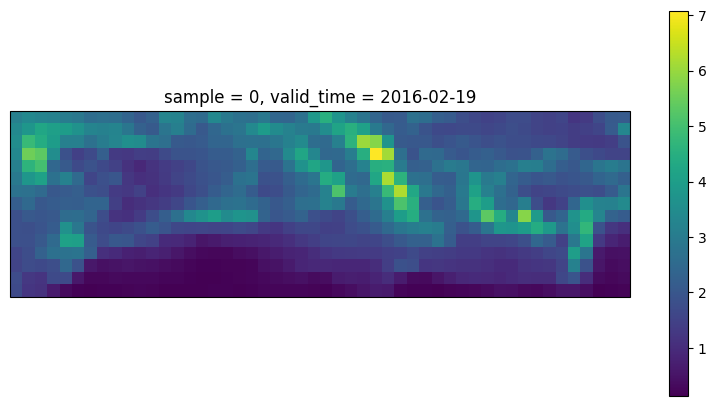

In [4]:
#plot one sample of pred_data 
sample = 0
valid_time = 0
# using cartopy
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# using colormesh
pred_data_transformed.isel(sample=sample, valid_time=valid_time).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=True)

In [37]:
# Assurez-vous que valid_time est en format datetime
if not np.issubdtype(pred_data_transformed.valid_time.dtype, np.datetime64):
    pred_data_transformed['valid_time'] = pred_data_transformed.valid_time.astype('datetime64')

# Sélectionnez les données entre décembre 2019 et décembre 2020
start_date = np.datetime64('2019-12-01')
end_date = np.datetime64('2020-12-31')

pred_data_selected = pred_data_transformed.where(
    (pred_data_transformed.valid_time >= start_date) & 
    (pred_data_transformed.valid_time <= end_date), 
    drop=True
)

pred_data_selected.valid_time


<xarray.DataArray 'valid_time' (sample: 9, valid_time: 3)>
array([['2019-11-19T00:00:00.000000000', '2019-11-26T00:00:00.000000000',
        '2019-12-03T00:00:00.000000000'],
       ['2019-12-10T00:00:00.000000000', '2019-12-17T00:00:00.000000000',
        '2019-12-24T00:00:00.000000000'],
       ['2019-12-31T00:00:00.000000000', '2020-01-07T00:00:00.000000000',
        '2020-01-14T00:00:00.000000000'],
       ['2020-01-21T00:00:00.000000000', '2020-01-28T00:00:00.000000000',
        '2020-02-04T00:00:00.000000000'],
       ['2020-02-11T00:00:00.000000000', '2020-02-18T00:00:00.000000000',
        '2020-02-25T00:00:00.000000000'],
       ['2020-03-03T00:00:00.000000000', '2020-03-10T00:00:00.000000000',
        '2020-03-17T00:00:00.000000000'],
       ['2020-11-19T00:00:00.000000000', '2020-11-26T00:00:00.000000000',
        '2020-12-03T00:00:00.000000000'],
       ['2020-12-10T00:00:00.000000000', '2020-12-17T00:00:00.000000000',
        '2020-12-24T00:00:00.000000000'],
       ['2020-12-31T00:00:00.000000000', '2021-01-07T00:00:00.000000000',
        '2021-01-14T00:00:00.000000000']], dtype='datetime64[ns]')
Coordinates:
  * sample      (sample) int64 20 21 22 23 24 25 26 27 28
    valid_time  (sample, valid_time) datetime64[ns] 2019-11-19 ... 2021-01-14

In [46]:
med_lats = [45,31]
med_lons = [170, 209;]

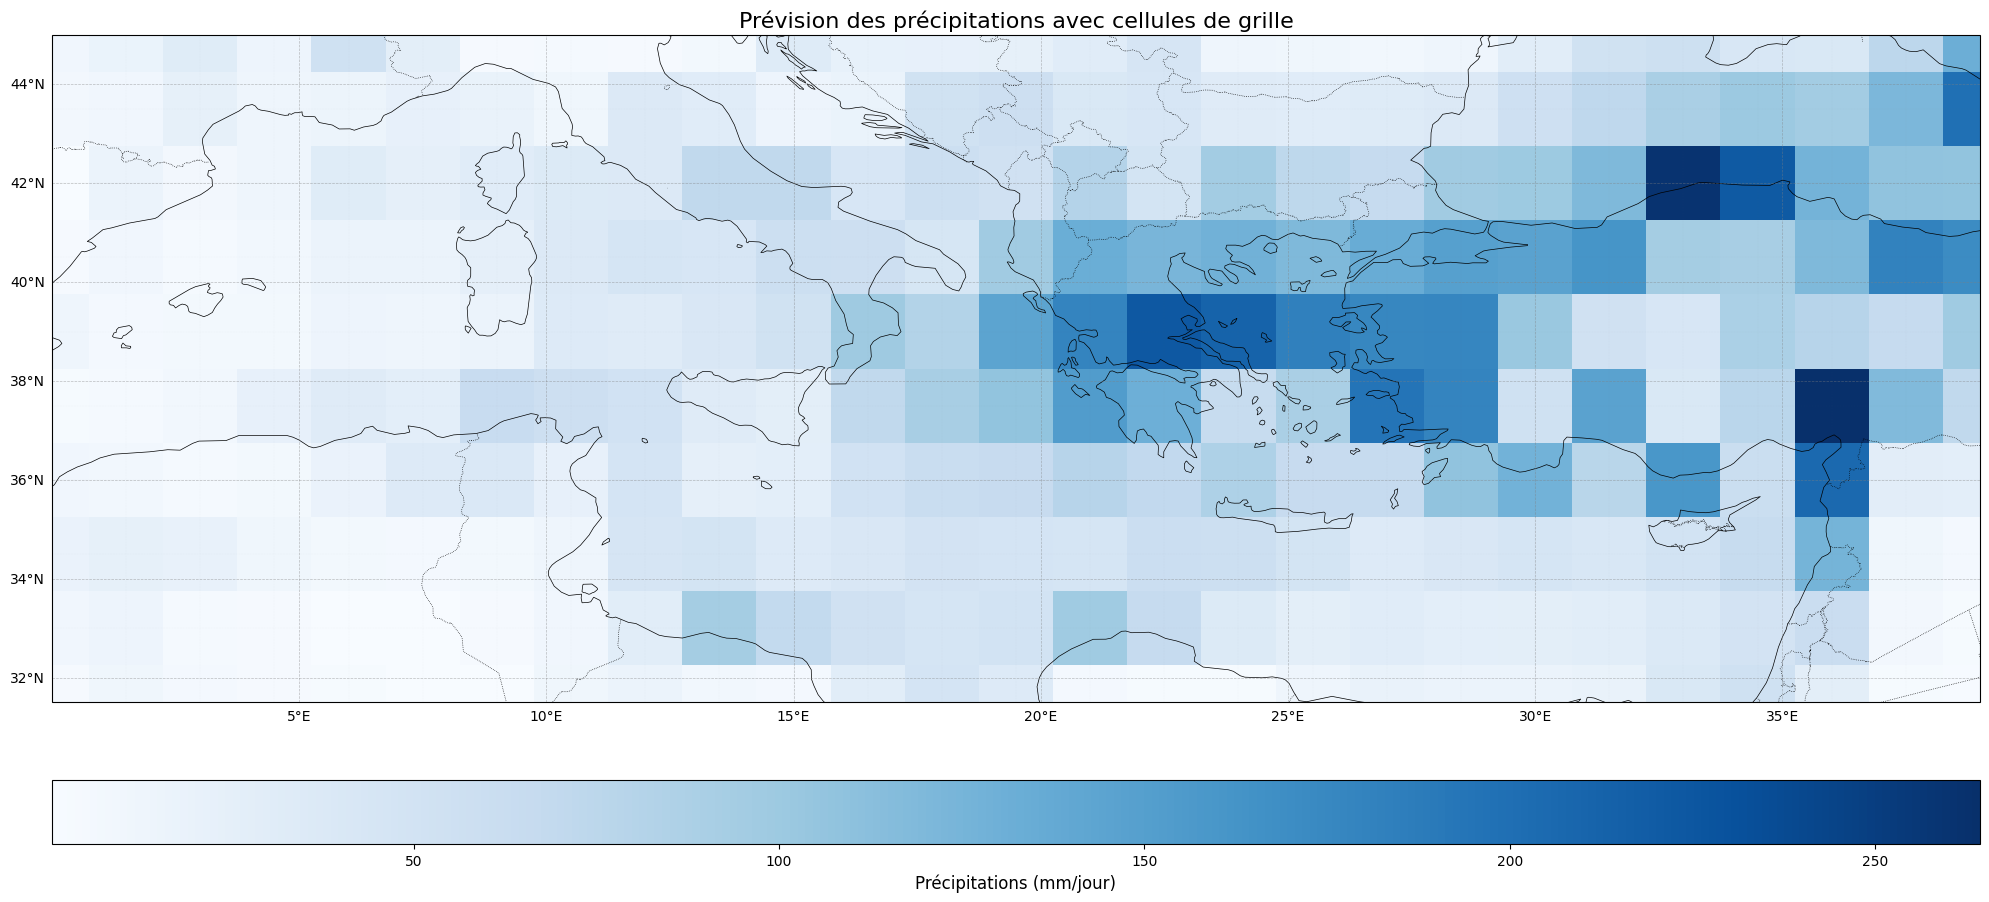

In [50]:

s2s_med = s2s.sel(latitude=slice(med_lats[0], med_lats[1]), longitude=slice(med_lons[0], med_lons[1]))
sample = s2s_med.isel(forecast_time=1).isel(realization=7)
sample = sample.isel(lead_time=30)
 

# Créer le plot
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

# Tracer les données
im = ax.pcolormesh(sample.longitude, sample.latitude, sample.values,
                   transform=ccrs.PlateCarree(), cmap='Blues')

# Ajouter les côtes et les frontières
ax.coastlines(resolution='50m', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# Ajouter les lignes de grille principales
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Obtenir la résolution des données
lat_res = np.abs(sample.latitude[1] - sample.latitude[0])
lon_res = np.abs(sample.longitude[1] - sample.longitude[0])

# Ajouter des lignes de grille mineures pour montrer les cellules individuelles
ax.gridlines(crs=ccrs.PlateCarree(), draw_la bels=False,
             linewidth=0.2, color='gray', alpha=0.2, linestyle=':',
             xlocs=np.arange(sample.longitude.min(), sample.longitude.max() + lon_res, lon_res),
             ylocs=np.arange(sample.latitude.min(), sample.latitude.max() + lat_res, lat_res))

# Définir les limites de la carte pour montrer seulement la zone de sample
ax.set_extent([sample.longitude.min(), sample.longitude.max(), 
               sample.latitude.min(), sample.latitude.max()], 
              crs=ccrs.PlateCarree())

# Ajouter une barre de couleur
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.08, aspect=30)
cbar.set_label('Précipitations (mm/jour)', fontsize=12)

plt.title('Prévision des précipitations avec cellules de grille', fontsize=16)
plt.tight_layout()
plt.show()

In [43]:
print(f"Résolution actuelle - Latitude: {lat_res:.4f}, Longitude: {lon_res:.4f}")

Résolution actuelle - Latitude: 1.5000, Longitude: 1.5000


In [ ]:
# on part du principe qu'ils ont la même résolution
# prenons les samples predictions dans mon dataset 
# pour chaque date dans les sample de predictions, trouver a quel forecast_time cette date appartient,
# et pour chaque forecast_time, trouver le lead_time correspondant pour qu'on tombe exactement sur la bonne date 
# c'est a dire si ma date de sample est month/day/2020 je veux que tu prennes la valeur de tp à (forecast-time + lead_time) - (forecast_time + lead_time - 7)



## biweekly aggregate 

In [ ]:
from climpred.utils import convert_Timedelta_to_lead_units

forecast = convert_Timedelta_to_lead_units(
    forecast_climetlab.rename({"lead_time": "lead"})
)


In [ ]:
# create 14D averages
forecast_w12 = forecast.sel(lead=range(1, 14)).mean(dim="lead")
forecast_w34 = forecast.sel(lead=range(14, 28)).mean(dim="lead")
forecast_w56 = forecast.sel(lead=range(28, 42)).mean(dim="lead")
forecast_biweekly = xr.concat([forecast_w12, forecast_w34, forecast_w56], dim="lead")
forecast_biweekly["lead"] = [
    1,
    14,
    28,
]  # lead represents first day of biweekly aggregate
forecast_biweekly["lead"].attrs["units"] = "days"
forecast_biweekly.coords


In [ ]:
# 14D rolling mean
obs_biweekly = obs_era.rolling(time=14, center=False).mean()
obs_biweekly = obs_biweekly.isel(time=slice(13, None)).assign_coords(
    time=obs_era.time.isel(time=slice(None, -13))
)  # time represents first day of the biweekly aggregate

In [ ]:
fct_biweekly = climpred.HindcastEnsemble(forecast_biweekly).add_observations(
    obs_biweekly
)

In [ ]:
obs_edges = (
    obs_biweekly.groupby("time.month")
    .quantile(q=[1 / 3, 2 / 3], dim="time", skipna=False)
    .rename({"quantile": "category_edge"})
)

In [ ]:
model_edges = (
    forecast_biweekly.rename({"forecast_time": "init", "realization": "member"})
    .groupby("init.month")
    .quantile(q=[1 / 3, 2 / 3], dim=["init", "member"], skipna=False)
    .rename({"quantile": "category_edge"})
)

In [ ]:
 # use the same observational category_edges for observations and forecasts
rps_same_edges = fct_biweekly.verify(
    metric="rps",
    comparison="m2o",
    alignment="same_inits",
    dim=["member", "init"],
    category_edges=obs_edges,
)

rps_same_edges.t2m.plot(col="lead", robust=True)

In [ ]:
# use different observational category_edges for observations and forecast category_edges for forecasts
rps_different_edges = fct_biweekly.verify(
    metric="rps",
    comparison="m2o",
    alignment="same_inits",
    dim=["member", "init"],
    category_edges=(obs_edges, model_edges),
)

rps_different_edges.t2m.plot(col="lead", robust=True)

In [ ]:
ds = climetlab.load_dataset(
    "era5-precipitations", period=(2020, 2023), domain="Ireland", time=12
)